In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from tkmodel.TwoCUM_copy import TwoCUMfittingConc
from tkmodel.TwoCUM_copy import TwoCUM

### Create Dataloader and Dataset

In [144]:
def generate_xy(num_curves):
    AIF = np.load("data/AIF.npy")
    data_size = AIF.shape[0]
    t = np.arange(0,366,2.45)

    E = np.random.rand(1,num_curves) #0 to 1 for both E and vp
    vp = np.random.rand(1,num_curves)
    Fp = np.random.rand(1,num_curves) #this will be multplied by 1e-5 to get the right scale at the end
    
    E_Fp = np.concatenate((E, Fp), axis =0)
    y = np.concatenate((E_Fp, vp), axis =0)


    x = np.zeros((num_curves, data_size))
    for i in range(num_curves):
        x[i] = TwoCUM(y[:,i], t, AIF, 0)

    y = y.T 
    
    return x,y


def create_dataloader(x, y, batch_size):
    
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()

    
    torch_dataset = Data.TensorDataset(x, y) 

    dataloader = Data.DataLoader(torch_dataset, batch_size=batch_size, shuffle=True) 
    
    return dataloader

### Define Network

In [145]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(150, 1000) 
        self.bn1 = nn.BatchNorm1d(1000)
        self.hidden2 = torch.nn.Linear(1000, 200) 
        self.bn2 = nn.BatchNorm1d(200)
        self.hidden3 = torch.nn.Linear(200, 200)
        self.bn3 = nn.BatchNorm1d(200)
        self.hidden4 = torch.nn.Linear(200, 200)
        self.bn4 = nn.BatchNorm1d(200)
        self.hidden5 = torch.nn.Linear(200, 200)
        self.bn5 = nn.BatchNorm1d(200)
        self.predict = torch.nn.Linear(200, 3)
        self.bound = torch.nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.bn1(self.hidden(x)) )     
        x = F.relu(self.bn2(self.hidden2(x)))
        x = F.relu(self.bn3(self.hidden3(x)))
        x = F.relu(self.bn4(self.hidden4(x)))
        x = F.relu(self.bn5(self.hidden5(x)))
        x = self.predict(x) 
        x = self.bound(x)
        return x

net = Net()

### Training Steps

In [156]:
def train(model, x, y, optimiser, criterion):
    model.train()
    model.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimiser.step()
       
    return loss, output

def test(model, x, y, criterion):
    with torch.no_grad():
        model.eval()
        output = model(x)
        loss = criterion(output, y)

    return loss, output

def normalise(x):
    x_trans = ( (x - x.mean() )/ x.std())
    return x_trans

### Run Training

In [157]:
#generate and normalise data
#training set
num_curves = 10000
x,y = generate_xy(num_curves)
x = normalise(x)

#validation set
x_val,y_val = generate_xy(int(num_curves/3))
x_val = normalise(x_val)


In [158]:

epochs = 100
batch_size = 50
optimiser = optimiser = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)

criterion = nn.MSELoss()
loss_plot = np.empty(epochs)
loss_val_plot = np.empty(epochs)

dataloader = create_dataloader(x, y, batch_size)
dataloader_val = create_dataloader(x_val, y_val, batch_size*5)
for epoch in range(epochs):

    for i, (train_x, train_y) in enumerate(dataloader):
        loss, predictions = train(net, train_x, train_y, optimiser, criterion)
    
    for i, (val_x, val_y) in enumerate(dataloader_val):
        loss_val, predictions_val = test(net, val_x, val_y, criterion)
        
    if epoch % 10 == 0:
        print(epoch)
        
    loss_plot[epoch] = loss.detach().numpy() 
    loss_val_plot[epoch] = loss_val.detach().numpy()


0
10
20
30
40
50
60
70
80
90


0.007349086459726095 0.03080741874873638
0.014049147255718708 0.07453546673059464


Text(0, 0.5, 'Loss')

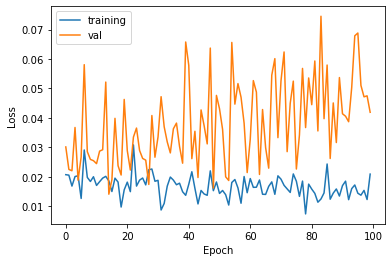

In [159]:
print(loss_plot.min(), loss_plot.max())
print(loss_val_plot.min(), loss_val_plot.max())

plt.plot(loss_plot, label = 'training')
plt.plot(loss_val_plot, label = 'val')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Testing
##### Tested using the training data (usually use a seperate testing dataset)

In [154]:
def plot_curves(prediction, target, AIF, t):
    predicted_curve = TwoCUM(prediction.detach().numpy(), t, AIF, 0)
    target_curve = TwoCUM(target.detach().numpy(), t, AIF, 0)
    
    plt.plot(t, predicted_curve, label = 'Prediction')
    plt.plot(t, target_curve, label = 'Target')
    plt.legend()
    plt.show()


 test


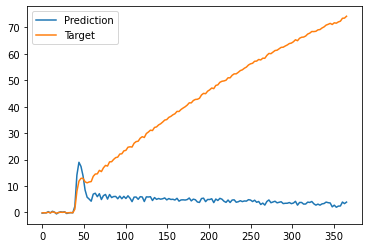

pred:  [0. 1. 1.] true:  [0.21804458 0.55521625 0.3726391 ]

 train


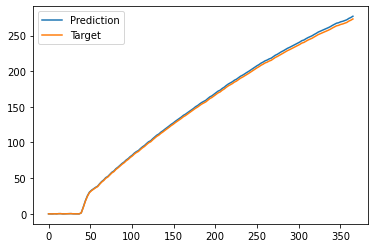

pred:  [0.7692616 0.5991563 0.4935769] true:  [0.805317   0.5646309  0.49435815]

 val


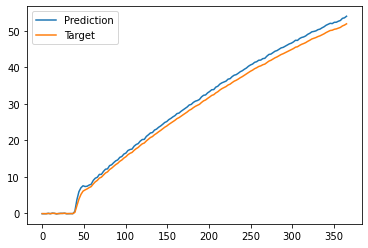

pred:  [0.3464259  0.25659373 0.09722424] true:  [0.61870545 0.13914695 0.4263397 ]


In [155]:
AIF = np.load("data/AIF.npy")
t = np.arange(0,366,2.45)

xt,yt = generate_xy(100)
dataloader_test = create_dataloader(xt, yt, 50)


for i, (test_x, test_y) in enumerate(dataloader_test):
    j = np.random.randint(0 ,test_x.shape[0])
    prediction_test = net(test_x)
    print('\n test')
    plot_curves(prediction_test[j], test_y[j], AIF, t)
    print('pred: ', prediction_test[j].detach().numpy(),'true: ', test_y[j].detach().numpy())
    
    break
    
for i, (train_x, train_y) in enumerate(dataloader):
    j = np.random.randint(0 ,train_x.shape[0])
    prediction = net(train_x)
    print('\n train')

    plot_curves(prediction[j], train_y[j], AIF, t)
    print('pred: ',prediction[j].detach().numpy(), 'true: ',train_y[j].detach().numpy())
        
    break
    
for i, (val_x, val_y) in enumerate(dataloader_val):
    j = np.random.randint(0 ,val_x.shape[0])
    prediction_val = net(val_x)
    print('\n val')

    plot_curves(prediction_val[j], val_y[j], AIF, t)
    print('pred: ',prediction_val[j].detach().numpy(), 'true: ',val_y[j].detach().numpy())
        
    break

### Results log
